<a href="https://colab.research.google.com/github/Richardjmorton/noise_gating/blob/master/wow_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/frederic-auchere/wavelets.git
%cd wavelets
!pip .

%cd ..

!git clone https://github.com/frederic-auchere/rectify.git
%cd rectify
!pip install .

%cd ..

!git clone https://github.com/frederic-auchere/wow.git
%cd wow
!pip install .

%cd ..

fatal: destination path 'wavelets' already exists and is not an empty directory.
/content/wavelets
ERROR: unknown command "."
/content
Cloning into 'rectify'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 7), reused 20 (delta 4), pack-reused 0
Unpacking objects: 100% (25/25), 15.58 KiB | 1.42 MiB/s, done.
/content/rectify
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/rectify
  Preparing metadata (setup.py) ... done
  Created wheel for rectify: filename=rectify-0.0.1-py3-none-any.whl size=10341 sha256=20c54f4c4c365a9dae9702722cf3faa67f8870b175e4569d97598e7d66b1d385
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgax_6m_/wheels/c6/bd/8b/aced9265fa27e5d087564b5dc679d1e9d9a0cb9d5ebc7c4211
Successfully built rectify
  Attempting uninstall: rectify
    Found existing installation: rectify 0.0.1
    Uninst

In [2]:
#!wget https://raw.githubusercontent.com/frederic-auchere/WISA/blob/master/solo_L2_eui-hrieuv174-image_20220317T040257234_V02.fits

In [41]:
# Just a convenience plotting function
def two_plots(images, titles, norms):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, img, title, norm in zip(axes.flatten(), images, titles, norms):
        ax.imshow(img[roi], origin='lower', norm=norm, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()

# Computes the peak signal-to-noise ratio
def psnr(reference, image):
    return 10*np.log10(np.max(reference)**2/np.mean((reference - image)**2))



(-0.5, 2047.5, -0.5, 2047.5)

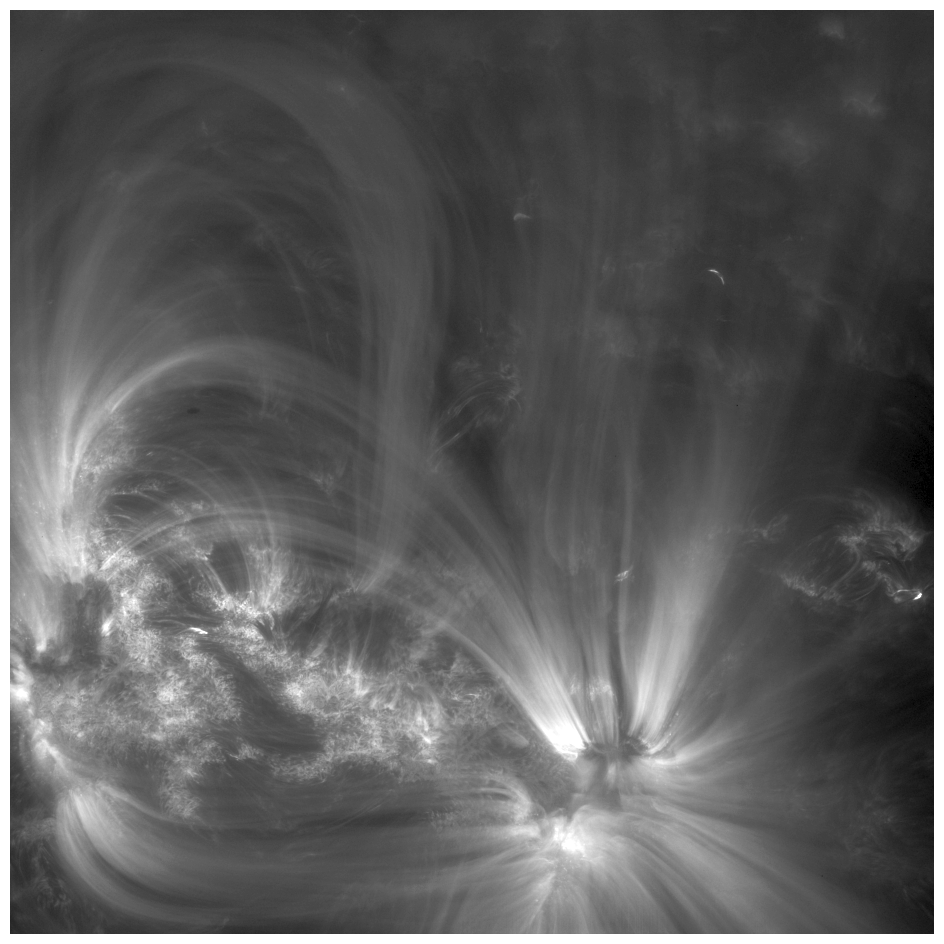

In [9]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, LinearStretch, PowerStretch, PercentileInterval
#from sunpy.visualization.colormaps import cm

with fits.open('solo_L2_eui-hrieuv174-image_20220317T040257234_V02.fits') as hdu_list:
    header = hdu_list[-1].header
    image = hdu_list[-1].data

image *= header['XPOSURE']  # L2 data is normalized to the exposure time. We will need values in DN, not DN/s later on.

gamma = 2.0
norm = ImageNormalize(image, stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.8))
fig, ax = plt.subplots(figsize=(12, 12))
#cmap = plt.get_cmap('solar orbiterhri_euv174')
ax.imshow(image, norm=norm, origin='lower', cmap='gray')
ax.axis('off')

In [ ]:
print(f"Image taken at {header['DSUN_AU']:.2f} AU")

In [31]:
from wavelets.watroo import AtrousTransform
transform = AtrousTransform()
denoise_sigma = [5, 3]
coefficients = transform(image, len(denoise_sigma))



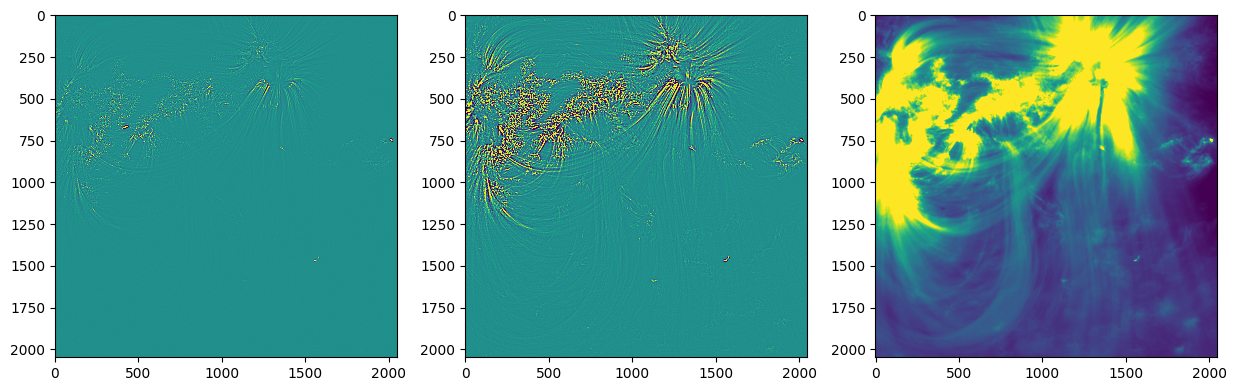

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

for axs, data in zip(ax,coefficients.data):
  data_stats = [data.mean(), data.std()]
  dmin= data_stats[0]-data_stats[1]
  dmax = data_stats[0]+data_stats[1]
  axs.imshow(data, vmin=dmin, vmax= dmax)

In [33]:
old = coefficients.data.copy()

# coefficients.data is a ndarray that contains the coefficients proper
coefficients.denoise(denoise_sigma, soft_threshold=False)


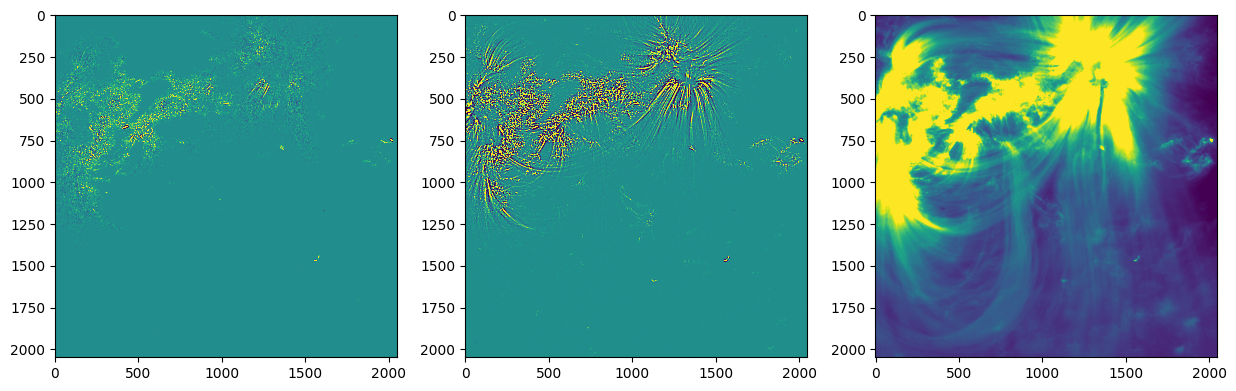

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

for axs, data in zip(ax,coefficients.data):
  data_stats = [data.mean(), data.std()]
  dmin= data_stats[0]-data_stats[1]
  dmax = data_stats[0]+data_stats[1]
  axs.imshow(data, vmin=dmin, vmax= dmax)

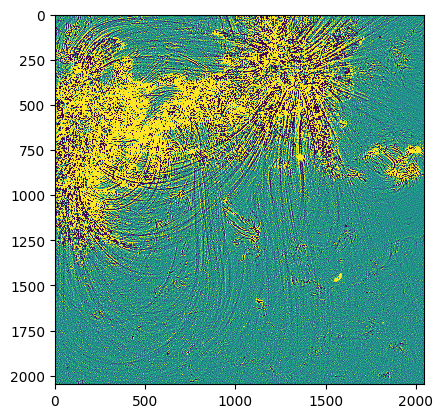

In [38]:
plt.imshow(coefficients.data[0]-old[0], vmax=10, vmin=-10)


In [39]:
from wavelets.watroo import denoise
denoised_gaussian_hard = denoise(image, denoise_sigma, soft_threshold=False)

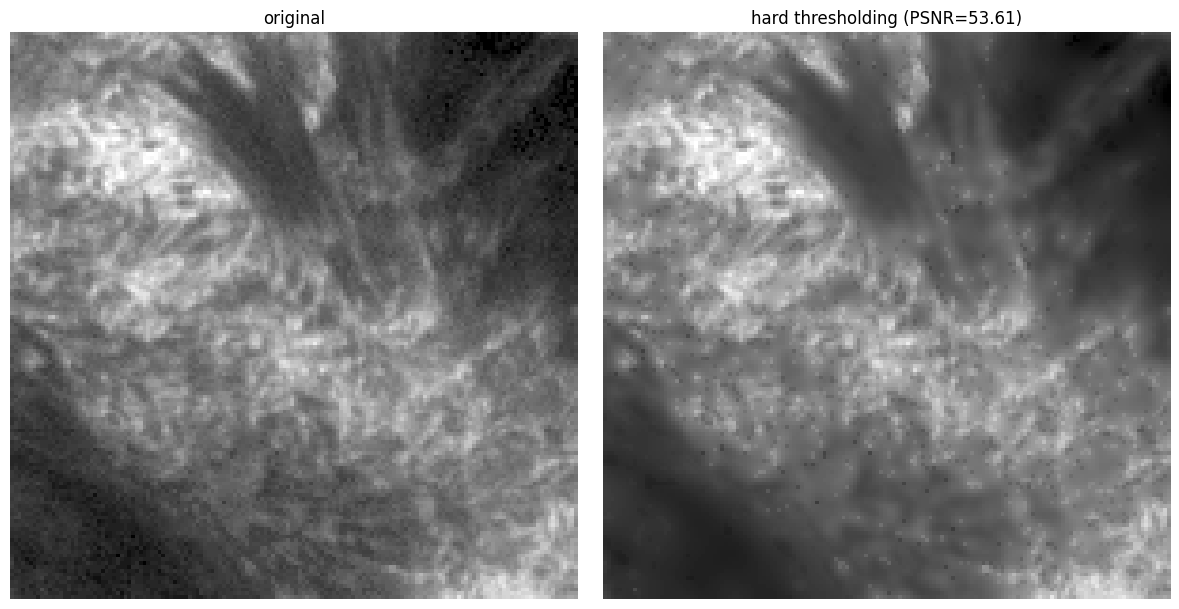

In [42]:
roi = slice(550, 700), slice(500, 650)  # define a region of interest

norm = ImageNormalize(denoised_gaussian_hard[roi], stretch=PowerStretch(1/gamma), interval=PercentileInterval(99.9))

two_plots([image, denoised_gaussian_hard],
          ['original', f'hard thresholding (PSNR={psnr(image, denoised_gaussian_hard):.2f})'],
          [norm, norm])

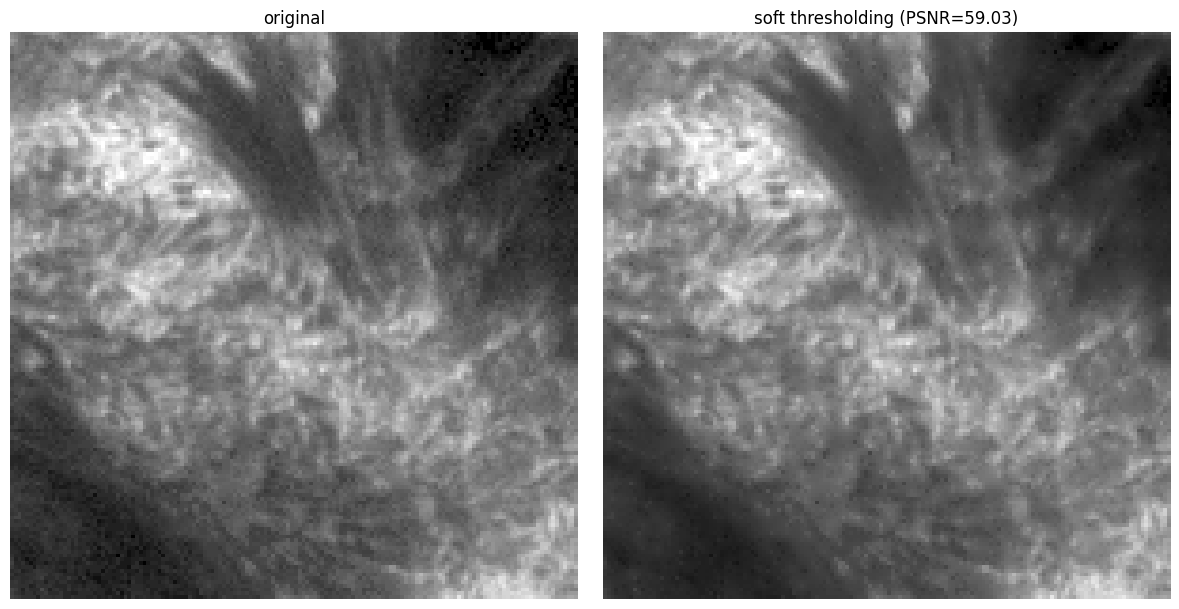

In [43]:


# denoise the input image with soft-thresholding (the default)
denoised_gaussian_soft = denoise(image, denoise_sigma)

two_plots([image, denoised_gaussian_soft],
          ['original', f'soft thresholding (PSNR={psnr(image, denoised_gaussian_soft):.2f})'],
          [norm, norm])

